# Generative Models

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Intuition

Imagine you have a set of data points $X_{1:N}:\{x_1, x_2, \dots, x_N\}$ sampled from a $\mathrm{\underline{known}}$ distribution $p(x)$, and we want to acquire more samples from $p(x)$

## Known Distribution $p(x)$ 

### Inverse sampling

We could potentially use [*Inverse Sampling*](https://en.wikipedia.org/wiki/Inverse_transform_sampling) method, where we first sample $\widetilde{u}$ from a uniform distribution $U[0, 1]$ and pass it to the inverse of the *CDF* of $p(x)$ to generate our new sample $\widetilde{x}$:

$\tilde{u} \sim U[0, 1] \, , \, \tilde{x} = CDF^{-1}_{p(x)}(\tilde{u})$

This method works only when $p(x)$ is quite starightforward and computing its inverse CDF is not difficult.
This however is not the case most of the times.

![Inverse Transform Sampling](https://theclevermachine.files.wordpress.com/2012/09/inversetransformstudent3.png?w=584)

[Inverse Transform Sampling Process](https://en.wikipedia.org/wiki/Inverse_transform_sampling#/media/File:Inverse_Transform_Sampling_Example.gif)

### Example: Gaussian Distribution

In [167]:
sizes = [1000]
mu0 = 0
std0 = 1
data0 = np.random.normal(mu0, std0, size=sizes[0])

In [168]:
(heights, bins) = np.histogram(data0, bins=10)
bins_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]

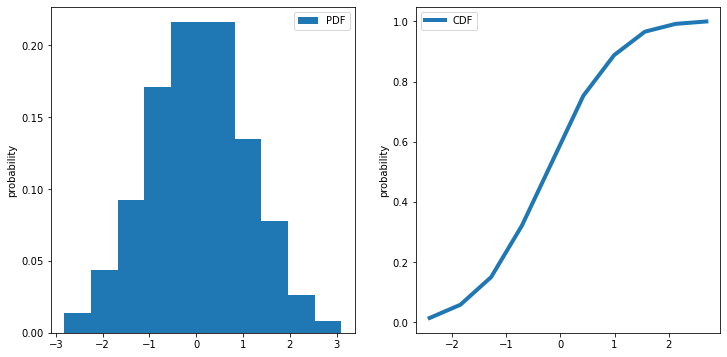

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(bins_centers, heights/sizes[0], label='PDF')
ax[0].set_ylabel('probability')
ax[0].legend()
ax[1].plot(bins_centers, np.cumsum(heights)/sizes[0], label='CDF', linewidth=4)
ax[1].set_ylabel('probability')
ax[1].legend()

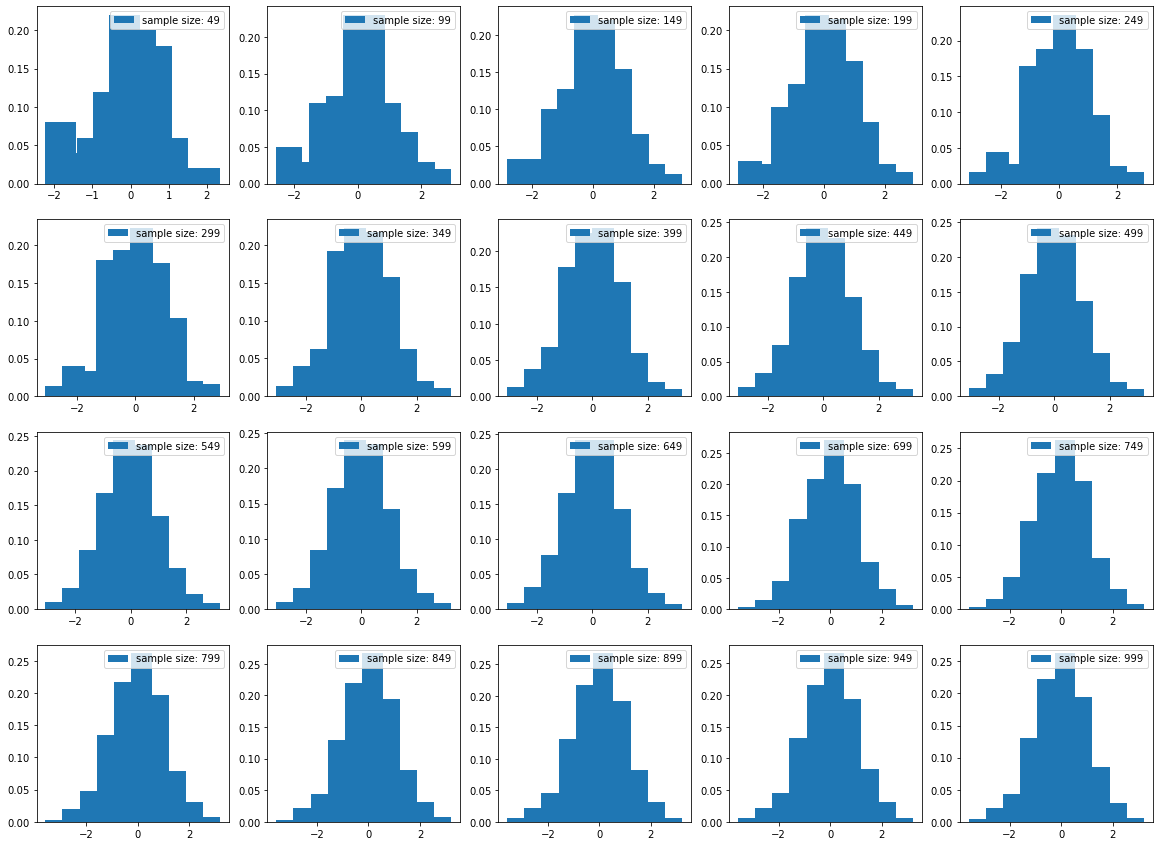

In [175]:
uniform_samples = np.random.uniform(0, 1, 1000)
generated_samples = []
fig, ax = plt.subplots(4, 5, figsize=(20, 15))
for i, z in enumerate(uniform_samples):
    generated_samples.append(norm.ppf(z, loc=mu0, scale=std0))
    if ((i+1) % 50) == 0:
        (sample_heights, sample_bins) = np.histogram(generated_samples, bins=10)
        sample_bins_centers = [(sample_bins[i] + sample_bins[i+1])/2 for i in range(len(sample_bins)-1)]
        ax[(i//50)//5, (i//50)%5].bar(sample_bins_centers, sample_heights/len(generated_samples), label=f'sample size: {i}')
        ax[(i//50)//5, (i//50)%5].legend()

### Rejection Sampling

In case $p(x)$ is quite convoluted such that inverse sampling is not feasible, one could possibly use [*Rejection Sampling*](https://en.wikipedia.org/wiki/Rejection_sampling) (a.k.a. accept/reject sampling). In this approach, a proposal distribution $q(x)$ with analytically closed form. Then an envelope function $e(x) = \alpha q(x)$ is created such that $e(x)=\alpha q(x) > p(x) \,\,\, \forall x, \,\,\, \alpha \ge 1$.
Then we follow this procedure:

At each iteration:

1) take a sample $\widetilde{x}$ from $q(x)$ and $\widetilde{u}$ from $U[0, 1]$. (*Remember that $q(x)$ must have been chosen to be an analytically simple distribution function, so taking a sample from it should be easy, e.g. using Inverse Sampling*).

2) If $\widetilde{u} < \frac{p(x)}{e(x)}$, accept the sample $\widetilde{x}$, otherwise reject it.

3) Go back to step-1 to try another sample.
![Rejection Sampling](files/rejectionsamplingcriterion.png)
Figure taken from: https://theclevermachine.wordpress.com/2012/09/10/rejection-sampling/

If we are lucky/clever and our proposal $e(x)$ is very close to the actual distribution $p(x)$, then we almost always get $\frac{p(x)}{e(x)} \approx 1$, hence most of the samples are accepted by our criteria, and sampling will be done faster.

Another example, where the underlying distribution is very intricate and we provide a simple proposal and scale it such that it envelopes the entire of our actual distribution and start the accept/reject sampling process:
![caption](files/RejectionSampling2.jpg)
Figure taken from: http://ct-cps.blogspot.com/2011/04/rejection-sampling-algorithm.html

### Example: Gaussian Mixture Model

In [137]:
sizes = [500, 1000]
mu0 = 0
std0 = 1
data0 = np.random.normal(mu0, std0, size=sizes[0])
mu1 = 6
std1 = 3
data1 = np.random.normal(mu1, std1, size=sizes[1])
# Combine two Gaussians into a GMM
selected_data = [data0.reshape(-1, 1), data1.reshape(-1, 1)]
synthetic_data = np.vstack(selected_data)

In [138]:
(heights, bins) = np.histogram(synthetic_data, bins=100)
bins_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]

#### Proposed distribution 

$q(x) = \frac{1}{5\sqrt{2\pi}}\exp\Big(-0.5\big(\frac{x - 5}{5}\big)^2\Big)$, $\alpha = 2$

In [149]:
x = np.linspace(-5, 15, 1000)
q_mu = 5
q_sigma = 5
alpha = 1.1
e_x = alpha * (1 / (q_sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * np.power((x - q_mu) / q_sigma, 2))
e_x_string = 'alpha * (1 / (q_sigma * (2*pi)**0.5)) * exp(-0.5 * ((x - q_mu) / q_sigma)**2)'

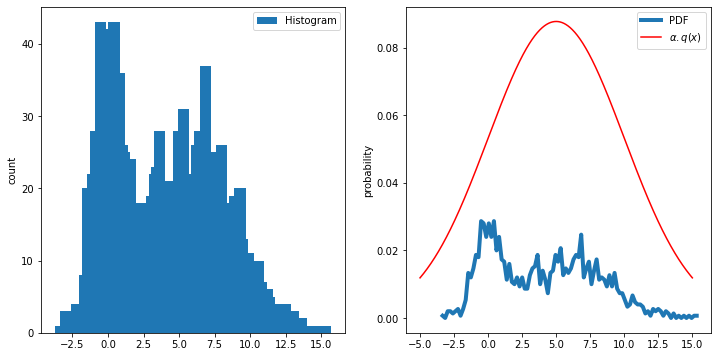

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(bins_centers, heights, label='Histogram')
ax[0].set_ylabel('count')
ax[0].legend()
ax[1].plot(bins_centers, heights/sum(sizes), label='PDF', linewidth=4)
ax[1].set_ylabel('probability')
ax[1].plot(x, e_x, color='r', label=r'$\alpha.q(x)$')
ax[1].legend()

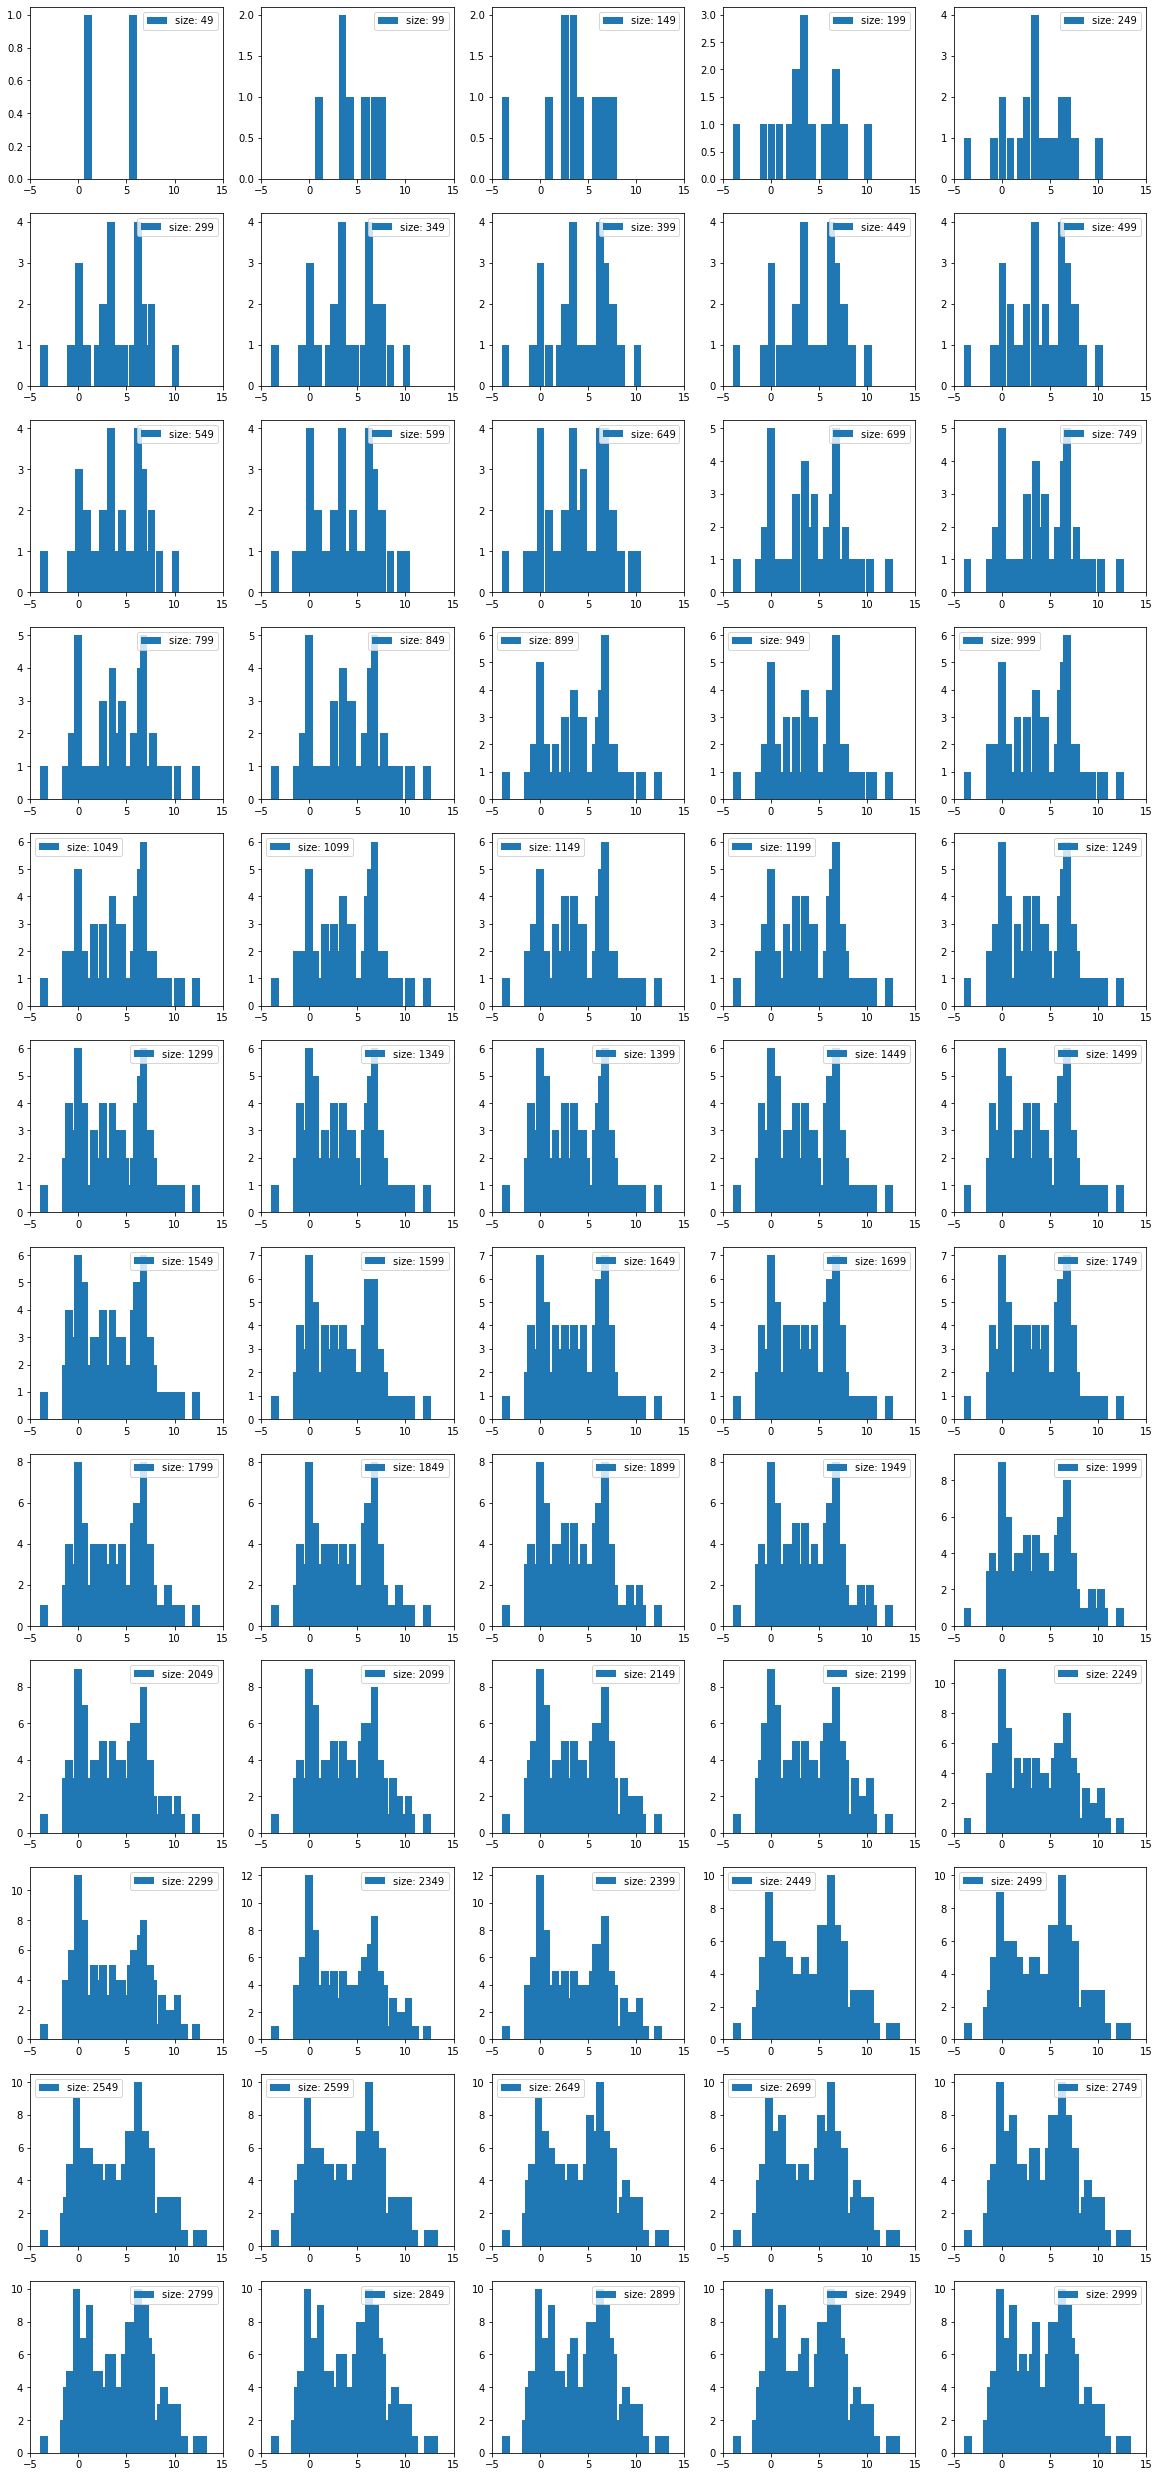

In [162]:
iteration_number = 3000
show_every = 50
uniform_samples = np.random.uniform(0, 1, iteration_number)
generated_samples = []
fig, ax = plt.subplots(int(iteration_number / (show_every * 5)), 5, 
                       figsize=(20, int(15 * iteration_number / 1000)))
for i, z in enumerate(uniform_samples):
    sample = norm.ppf(z, loc=q_mu, scale=q_sigma)
    nearest_bin = np.argmin(np.abs(np.array(bins_centers) - sample))
    x = bins_centers[nearest_bin]
    p_x = heights[nearest_bin]/sum(sizes)
    e_x = f.subs({'x': 5, 'q_sigma': q_sigma, 'q_mu': q_mu, 'alpha': alpha}).evalf()
    u = np.random.uniform(0, 1, 1)[0]
    if u >= (p_x / e_x):
        # Reject
        pass
    else:
        generated_samples.append(sample)
    if ((i+1) % show_every) == 0:
        (sample_heights, sample_bins) = np.histogram(generated_samples, bins=50)
        sample_bins_centers = [(sample_bins[i] + sample_bins[i+1])/2 for i in range(len(sample_bins)-1)]
        ax[(i//show_every)//5, (i//show_every)%5].bar(sample_bins_centers, sample_heights, label=f'size: {i}')
        ax[(i//show_every)//5, (i//show_every)%5].legend()
        ax[(i//show_every)//5, (i//show_every)%5].set_xlim([-5, 15])

#### Number of accepted samples

In [166]:
print(f'{len(generated_samples)} samples out of total {len(uniform_samples)} generated samples were accepted.')

194 samples out of total 3000 generated samples were accepted.


### Other Sampling Methods

For high-dimensional data, Rejection sampling is super inefficient as a lot of samples are rejected due to the curse of dimensionality. Therefore, people tend to use other methods such as Importance Sampling, MCMC, Gibbs sampling, etc.

## Unknown distribution $p(x)$ 

Let's take make our problem a bit more complicated by assuming that we don't know the underlying distribution $p(x)$ and all we know about it is a set of already withdrawn samples $X_{1:N}:\{x_1, x_2, \dots, x_N\}$ .(e.g. a number of paintings drawn by an artist from 18th century).

Previously when we knew $p(x)$, we started from a uniformly sampled variable $\widetilde{u}$ and used either Inverse sampling, Rejection sampling, MCMC, or other methods to get from $\widetilde{u}$ to $\widetilde{x}$. (For instance, $\widetilde{u} \xrightarrow{CDF^{-1}_{p(x)}} \widetilde{x}$).
In other words, our knowledge about $p(x)$ was used in order to find the mapping. 

However, when $p(x)$ is unknown, this information is missing and we have to fill the black-box between $\widetilde{u}$ and $\widetilde{x}$ with some other technique. The main idea behind GANs is to use a **Generator** neural network to model that mapping $\widetilde{u} \xrightarrow{G(\theta)} \widetilde{x}$.

### Generative Adversarial Network (GAN)

### Training the Generator $G(\theta)$ (by training a discriminator $D(\phi)$)

The generator network needs to learn how to map the input uniform sample to the real samples. One way would be to define a reconstruction loss function for it: $L = \|\widetilde{x} - x\|^2$. This direct comparison of the distribution samples and generated samples is not very straightforward and also does not produce good new samples.

Instead, we assess our generated samples in another way, by introducing a neural network called **discriminator** $D(\phi)$. Discriminator is trained to differentiate between the fake/generated samples and the real samples. In other words, at each iteraion of GAN training, the samples generated by $G(\widetilde{u}; \theta)$ are examined by $D(\widetilde{x}; \phi)$. The discriminator is trained to properly separate fake data from real data (two-class supervised learning). Moreover, Generator is trained such that its generated samples get a positive prodeiction from the discriminator. As we continue with this training process, Discriminator gets better and better at distinguishing positive and negative classes, and Generator gets better and better at generaing real-looking samples. This battle continues until discriminator cannot discriminate anymore!

Mathematically speaking, the objective of discriminator is a binary cross-entropy over positive labels (real data: $x$) and negative labels (fake data: $G(\widetilde{u}; \theta)$):

\begin{equation} 
\max_D\Bigg\{E_{x\sim p(x)}\Big[\log\big(D(x; \phi\big)\Big] \, + \, E_{\widetilde{u}\sim U[0, 1]}\Big[\log\big(1 - D\big(G(\widetilde{u}; \theta); \phi\big)\big)\Big]\Bigg\}
\tag{I}
\end{equation} 

In this objective function, $\theta$ is fixed and we only update the parameters of $D$ (i.e. $\phi$).


At the same time the objective of generator is to maximise the probability of getting a positive prediction label from the discriminator, or in other words, minimizing the value of $1 - D\big(G(\widetilde{u}; \theta); \phi\big)$ (while discriminator parameters, $\phi$, are fixed:
\begin{equation} 
\min_G\Big\{E_{\widetilde{u}\sim U[0, 1]}\big[\log(1 - D\big(G(\widetilde{u}; \theta); \phi\big)\big]\Big\}
\end{equation} 

In order to make this objective function more stable (c.f. page 116 in your hand-written notebook), it is re-written as:
\begin{equation} 
\max_G\Big\{E_{\widetilde{u}\sim U[0, 1]}\big[\log( D\big(G(\widetilde{u}; \theta); \phi\big)\big]\Big\}
\tag{II}
\end{equation} 

Now, the training process will alternately perform gradient ascent (or gradient descent on negative of these two log-likelihoods (equations **I** and **II**)) to update the networks and thereby, generate real-looking samples as a result.

### Define the Generator and Discriminator

In [176]:
class Generator(nn.Module):
    def __init__(self, latent_dim=5, output_dim=2, hidden_sizes=(10, 5)):
        super().__init__()
        layers = []
        layers.extend([nn.Linear(latent_dim, hidden_sizes[0]),
                       nn.BatchNorm1d(hidden_sizes[0]),
                       nn.ReLU6(inplace=True)])
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.ReLU6(inplace=True))
        layers.append(nn.Linear(hidden_sizes[-1], output_dim))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        out = torch.sigmoid(x)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_dim=2, hidden_sizes=(10, 5), dropout_p=0.2):
        super().__init__()
        layers = []
        layers.extend([nn.Linear(input_dim, hidden_sizes[0]),
                       nn.LeakyReLU(0.2, inplace=True),
                       nn.Dropout(dropout_p)])
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Dropout(dropout_p))
        layers.append(nn.Linear(hidden_sizes[-1], 2))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Underlying distribution:

In [177]:
sizes = [1000, 1000, 1000]
mu0 = np.array([-13, 15])
cov0 = np.array([[6, 5], [5, 6]])
data0 = np.random.multivariate_normal(mu0, cov0, size=sizes[0])
mu1 = np.array([0, -3])
cov1 = np.array([[20, 0], [0, 1]])
data1 = np.random.multivariate_normal(mu1, cov1, size=sizes[1])
mu2 = np.array([10, 13])
cov2 = np.array([[3, 0], [0, 3]])
data2 = np.random.multivariate_normal(mu2, cov2, size=sizes[2])

selected_data = [data0, data1, data2]

In [178]:
synthetic_data = np.vstack(selected_data)

### Visualise the real data

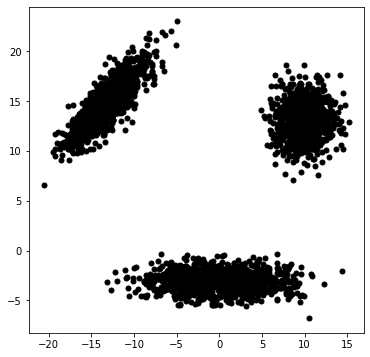

In [179]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(synthetic_data[:, 0], synthetic_data[:, 1], 
        '.', markersize=10, color='k')

In [180]:
class RealDataGenerator(Dataset):
    def __init__(self, numpy_data, maxim=None, minim=None):
        super().__init__()
        if minim is not None:
            numpy_data = numpy_data - minim
        if maxim is not None:
            numpy_data = numpy_data / (maxim - minim)
        self.data = numpy_data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        item = self.data[idx, :]
        return item

In [181]:
data_max = synthetic_data.max(axis=0, keepdims=1)
data_min = synthetic_data.min(axis=0, keepdims=1)
synthetic_data_normalised = (synthetic_data - data_min) / (data_max - data_min)
batch_size = 128
dataloader = DataLoader(RealDataGenerator(synthetic_data,
                                          data_max,
                                          data_min),
                        batch_size=batch_size, shuffle=True)

In [182]:
len(dataloader)

24

### Visualise the data coming from the dataloader

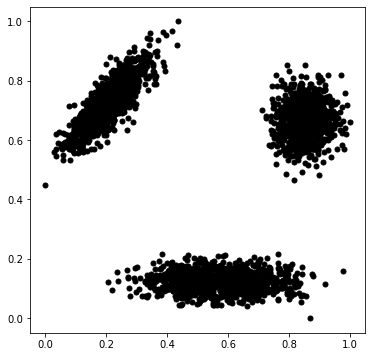

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for idx, batch in enumerate(dataloader):
    batch_numpy = batch.data
#     print(batch_numpy.shape)
    ax.plot(batch_numpy[:, 0], batch_numpy[:, 1], 
            '.', markersize=10, color='k')
plt.show()

### Train the models

At each iteration, the discriminator is trained first using two batches of data from real samples and fake samples.
Then the generator is trained by setting its target to be positive and updating its parameters to make the predictions of its generated samples to be close to this fake target.

In [184]:
def train_gan(generator, discriminator, latent_dim, dataloader,
              optimizer_G, optimizer_D, device, n_epochs,
              synthetic_data_normalised):
    for epoch in range(n_epochs + 1):
#         print(f"\n epoch {epoch}:")
        for idx, batch in enumerate(dataloader):
            bs = batch.shape[0]
            real_data = batch.to(device)
            real_data_labels = torch.ones(bs, 1).to(device)

            generator.to(device)
            discriminator.to(device)

            # ------------------------------------
            # Training the Discriminator:
            # ------------------------------------
            # generator.requires_grad_(False)
            # discriminator.requires_grad_(True)

            # generate fake data:
            input_noise = torch.rand(bs, latent_dim).to(device)
            fake_data = generator(input_noise)
            fake_data_true_labels = torch.zeros(bs, 1).to(device)

            # Combine reak and fake data into one training batch
            data_combined = torch.cat([real_data.double(),
                                       fake_data.double()], dim=0)
            labels_combined = torch.cat([real_data_labels, fake_data_true_labels], dim=0)

            # Shuffle the real and fake data
            perm = torch.randperm(bs * 2)
            labels_combined = labels_combined[perm, :]
            data_combined = data_combined[perm, :]

            # Check the discriminator output and update its parameters
            optimizer_D.zero_grad()
            discriminator_output = discriminator(data_combined.float())
            loss = F.cross_entropy(discriminator_output, labels_combined.long().view(-1))
            loss.backward()
            optimizer_D.step()

            # ------------------------------------
            # Training the Generator:
            # ------------------------------------
            # G.requires_grad_(True)
            # D.requires_grad_(False)

            input_noise = torch.rand(bs, latent_dim).to(device)
            fake_data = generator(input_noise)
            fake_data_fake_labels = torch.ones(bs, 1).to(device)

            optimizer_G.zero_grad()
            discriminator_output = discriminator(fake_data.float())
            loss = F.cross_entropy(discriminator_output, fake_data_fake_labels.long().view(-1))
            loss.backward()
            optimizer_G.step()
        if epoch % 50 == 0:
            input_noise = torch.rand(synthetic_data_normalised.shape[0],
                                     latent_dim).to(device)
            fake_data = generator(input_noise)
            batch_numpy = fake_data.cpu().data
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(synthetic_data_normalised[:, 0],
                       synthetic_data_normalised[:, 1],
                       '.', markersize=3, marker='*', color='b')
            ax[0].set_title('Real Data')
            ax[1].plot(batch_numpy[:, 0], batch_numpy[:, 1],
                       '.', markersize=3, marker='s', color='k')
            ax[1].set_title(f'Generated data at epoch {epoch}')
            plt.show()

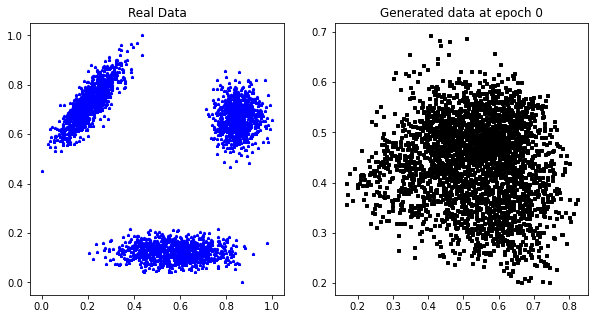

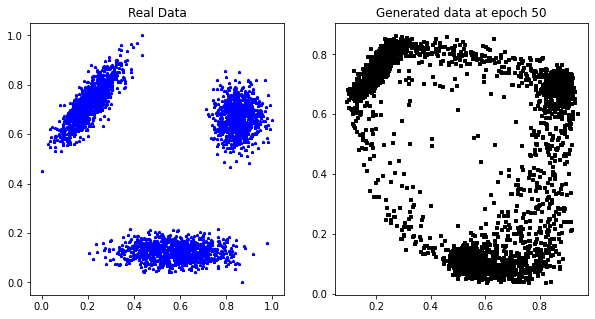

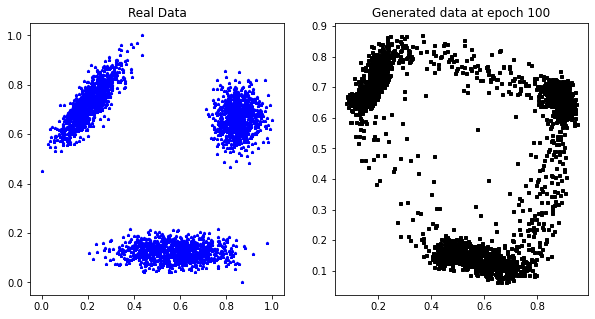

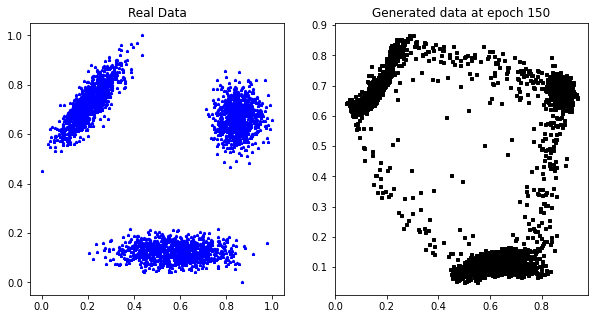

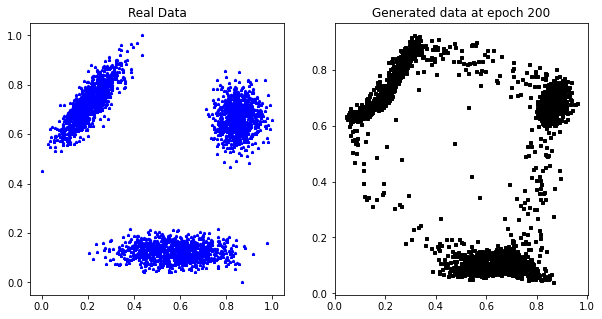

KeyboardInterrupt: 

In [185]:
lr = 0.0002
n_epochs = 500
latent_dim = 5
output_dim = synthetic_data.shape[1]
hidden_sizes_gen = (100, 50, 50)
hidden_sizes_dis = (100, 50, 50)
dropout_p = 0.1
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Instantiate the Generator and Discriminator
generator = Generator(latent_dim, output_dim, hidden_sizes_gen)
discriminator = Discriminator(output_dim, hidden_sizes_dis, dropout_p)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


train_gan(generator, discriminator, latent_dim, dataloader,
          optimizer_G, optimizer_D, device, n_epochs,
          synthetic_data_normalised)

### https://thispersondoesnotexist.com/